In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("spam.csv")
df = df.drop(df.loc[:, "char_freq_;" : "capital_run_length_total"], axis=1)
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.0,0.0,0.12,0.00,0.06,0.06,0.0,0.0,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.31,0.31,0.31,0.0,0.0,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.0,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,1.20,0.0,0.0,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.32,0.00,0.32,0.0,0.0,0


In [6]:
def split_dataset(data, part_for_test=0.1):
    inds = np.random.choice(len(data), size=int(len(data) * part_for_test), replace=False)
    train = data.drop(inds, axis=0)
    test = data.iloc[inds, :]
    return train, test

In [7]:
train_df, test_df = split_dataset(df)
feats = df.columns.drop("spam")
target = "spam"

In [8]:
class KNNClassifier:
    def __init__(self, train_feats, train_targs, k, similarity="product"):
        self.train_feats = train_feats
        self.train_targs = train_targs
        self.k = k
        self.vec_classify = np.vectorize(self.classify)
        self.similarity = similarity
    

    def classify(self, test_feats):
        if len(test_feats) > 1:
            predictions = pd.Series(dtype=int)
            for i in range(0, len(test_feats)):
                predictions.loc[test_feats.index[i]] = self.classify(test_feats.iloc[i:i+1])
            return predictions
        if self.similarity == "product":
            sims = test_feats @ self.train_feats.T
        elif self.similarity == "euclidian":
            sims = self.train_feats.apply(lambda x: 1 / np.linalg.norm(x-test_feats), axis=1)
            sims = pd.DataFrame([sims], index=[test_feats.index[0]])
        else:
            raise IndexError("LOOOH")
        sims = sims.sort_class_typeues(by=sims.index[0], axis=1, ascending=False)
        knn = np.array(sims.columns[:self.k])

        neighb_classes = self.train_targs.loc[knn].class_typeues
        prediction = np.bincount(neighb_classes).argmax()
        
        return prediction
        

In [9]:
class BayesianClassifier:
    def __init__(self, train_feats, train_targs, smoothing_m=1):
        self.train_feats = (train_feats > 0).astype(int)
        self.train_targs = train_targs
        self.p = 1 / np.unique(train_targs).size
        self.m = smoothing_m

    def calc_likelihood(self, curr_class_df, instance):
        likelihoods = np.array([])
        for predictor in curr_class_df.columns:
            n_good = len(curr_class_df[curr_class_df[predictor] == instance.loc[predictor]])
            n_total = len(curr_class_df)
            likelihoods = np.append(likelihoods, (n_good + self.m * self.p) / (n_total + self.m))

        return np.product(likelihoods)

    def classify(self, test_feats):
        if len(test_feats) > 1:
            predictions = pd.Series(dtype=int)
            for i in range(0, len(test_feats)):
                predictions.loc[test_feats.index[i]] = self.classify(test_feats.iloc[i:i+1])
            return predictions

        class_types, counts = np.unique(self.train_targs, return_counts=True)
        freqs = counts / self.train_targs.size
        priors = pd.Series(freqs, index=class_types)
        
        posteriors = pd.Series(dtype=np.float64)
        for class_type in class_types:
            curr_class_df = self.train_feats[self.train_targs == class_type]
            freqs = curr_class_df.mean()
            instance = test_feats.iloc[0]
            
            likelihood = self.calc_likelihood(curr_class_df, instance)

            posteriors.loc[class_type] = likelihood * priors.loc[class_type]
        
        return posteriors.argmax()
        

In [18]:
def entropy(v):
    _, counts = np.unique(v, return_counts=True)
    freqs = counts / len(v)
    return sum(-1 * freqs * np.log2(freqs))


class Node:
    def __init__(self, features, targets):
        self.data = {"feats": features, "targs": targets}
        self.is_leaf = self._check_if_leaf()
    
    def _find_best_predictor(self):
        pass

    def _check_if_leaf(self):
        unique_targs = np.unique(self.data["targs"])
        return (len(unique_targs) < 2)


In [415]:
clf = BayesianClassifier(train_feats=train_df[feats], train_targs=train_df[target], smoothing_m=100)
(clf.classify(test_df[feats]) == test_df[target]).mean()

0.7282608695652174

In [309]:
clf = KNNClassifier(train_feats=train_df[feats], train_targs=train_df[target], k=3, similarity="product")
(clf.classify(test_df[feats]) == test_df[target]).mean()

0.6456521739130435

In [268]:
ks = np.arange(1, 1000, 20)
feats = df.columns.drop("spam")
n_of_trials = 1
target = "spam"
k_to_acc_test = pd.Series(dtype=np.float64)
# k_to_acc_train = pd.Series(dtype=np.float64)
for k in ks:
    accs_test = np.array([])
    # accs_train = np.array([])
    for _ in range(0, n_of_trials):
        train_df, test_df = split_dataset(df)
        clf = KNNClassifier(train_feats=train_df[feats], train_targs=train_df[target], k=k)
        acc_test = (clf.classify(test_df[feats]) == test_df[target]).mean()
        accs_test = np.append(accs_test, acc_test)
        # acc_train = (clf.classify(train_df[feats]) == train_df[target]).mean()
        # accs_train = np.append(accs_train, acc_train)
    k_to_acc_test.loc[k] = accs_test.mean()
    # k_to_acc_train.loc[k] = accs_train.mean()

Text(0, 0.5, 'Accuracy')

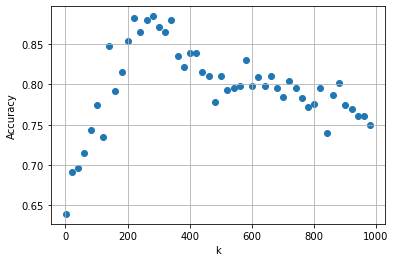

In [269]:
fig, ax = plt.subplots()
ax.scatter(k_to_acc_test.index, k_to_acc_test.class_typeues)
ax.grid()
ax.set_xlabel("k")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'Train Accuracy')

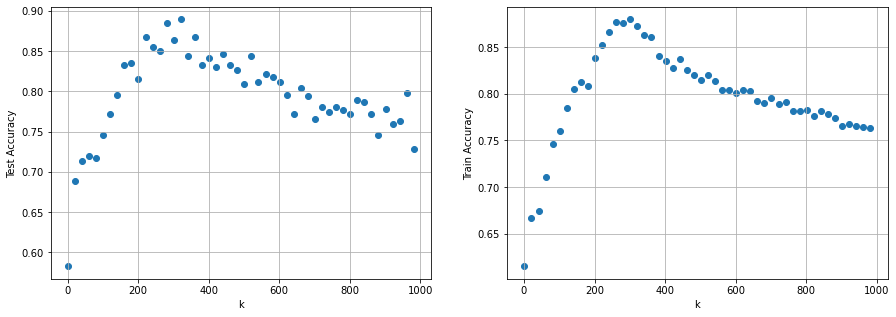

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(k_to_acc_test.index, k_to_acc_test.class_typeues)
ax[0].grid()
ax[0].set_xlabel("k")
ax[0].set_ylabel("Test Accuracy")

ax[1].scatter(k_to_acc_train.index, k_to_acc_train.class_typeues)
ax[1].grid()
ax[1].set_xlabel("k")
ax[1].set_ylabel("Train Accuracy")